# MDSC-302(P) Deep Learning Practicals
# Assignment-5

#Name : Guru Prasanth R S
#Regd No : 240402008003
#Chapter 7: Telling birds from airplanes: Learning from images

# 7.1 — A Dataset of Tiny Images (CIFAR-10)

In this section, we explore the `CIFAR-10 dataset`, a classic benchmark in computer vision.
It consists of `60,000 color images (32×32 pixels)` divided into `10 classes`:

`airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck`

We will:

- Download and inspect the CIFAR-10 dataset using torchvision.datasets.
- Understand how PyTorch’s Dataset class works (__len__, __getitem__).
- Convert images to tensors using transforms.ToTensor().
- Normalize the dataset so each color channel has zero mean and unit variance.

In [1]:
# Import required libraries
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Define data path
data_path = './data/'

# Download the CIFAR-10 dataset (train and validation)
cifar10 = datasets.CIFAR10(root=data_path, train=True, download=True)
cifar10_val = datasets.CIFAR10(root=data_path, train=False, download=True)

print("Training dataset size:", len(cifar10))
print("Validation dataset size:", len(cifar10_val))

100%|██████████| 170M/170M [00:13<00:00, 12.5MB/s]


Training dataset size: 50000
Validation dataset size: 10000


Understanding the Dataset class

A Dataset in PyTorch is an object that:
- Implements __len__() → returns the number of samples.
- Implements __getitem__() → returns one data sample and its label.

(<class 'torchvision.datasets.cifar.CIFAR10'>, <class 'torchvision.datasets.vision.VisionDataset'>, <class 'torch.utils.data.dataset.Dataset'>, <class 'typing.Generic'>, <class 'object'>)
Number of training samples: 50000
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Label index: 1
Class name: automobile


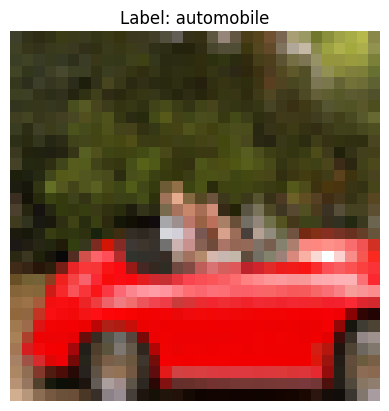

In [2]:
# Check inheritance hierarchy (class resolution order)
print(type(cifar10).__mro__)

# Get length of dataset
print("Number of training samples:", len(cifar10))

# CIFAR-10 class names
class_names = cifar10.classes
print("Classes:", class_names)

# Get one sample
img, label = cifar10[99]
print("Label index:", label)
print("Class name:", class_names[label])

# Display the image
plt.imshow(img)
plt.title(f"Label: {class_names[label]}")
plt.axis("off")
plt.show()

Transforming Images into Tensors

Currently, images are in PIL (Python Imaging Library) format.
To use them with PyTorch models, we convert them into tensors using transforms.ToTensor().

This:
- Converts image values from 0–255 to 0.0–1.0.
- Changes image layout from (H, W, C) to (C, H, W).

Tensor shape: torch.Size([3, 32, 32])
Tensor dtype: torch.float32
Value range: (0.0, 1.0)


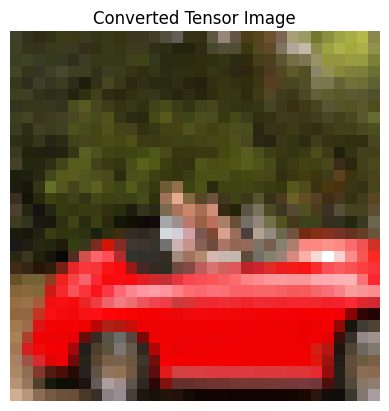

In [3]:
# Convert PIL image to tensor
to_tensor = transforms.ToTensor()
img_t = to_tensor(img)

print("Tensor shape:", img_t.shape)
print("Tensor dtype:", img_t.dtype)
print("Value range:", (img_t.min().item(), img_t.max().item()))

# Display tensor as image (convert back to HWC for matplotlib)
plt.imshow(img_t.permute(1, 2, 0))
plt.title("Converted Tensor Image")
plt.axis("off")
plt.show()

Creating a Tensor Dataset

We can automatically apply a transform to every image by passing it to the dataset.
This way, each sample is already a tensor when loaded.

In [4]:
# Create a version of the dataset where every image is already a tensor
tensor_cifar10 = datasets.CIFAR10(
    root=data_path, train=True, download=False,
    transform=transforms.ToTensor()
)

# Test it
img_t, label_t = tensor_cifar10[99]
print(type(img_t))
print("Tensor shape:", img_t.shape)
print("Tensor dtype:", img_t.dtype)

<class 'torch.Tensor'>
Tensor shape: torch.Size([3, 32, 32])
Tensor dtype: torch.float32


Normalizing the Dataset

Normalization ensures that:
- Each RGB channel has zero mean and unit standard deviation.
- This helps the neural network learn efficiently.

We’ll compute the mean and standard deviation across the dataset, then apply normalization using `transforms.Normalize`.

In [5]:
# Stack all tensors in memory to compute statistics
imgs = torch.stack([img_t for img_t, _ in tensor_cifar10], dim=3)
print("Stacked tensor shape:", imgs.shape)

# Compute mean and std for each channel (R, G, B)
mean = imgs.view(3, -1).mean(dim=1)
std = imgs.view(3, -1).std(dim=1)

print("Channel-wise mean:", mean)
print("Channel-wise std:", std)

Stacked tensor shape: torch.Size([3, 32, 32, 50000])
Stacked tensor shape: torch.Size([3, 32, 32, 50000])
Channel-wise mean: tensor([0.4914, 0.4822, 0.4465])
Channel-wise std: tensor([0.2470, 0.2435, 0.2616])
Channel-wise mean: tensor([0.4914, 0.4822, 0.4465])
Channel-wise std: tensor([0.2470, 0.2435, 0.2616])


Applying Normalization with `transforms.Compose`

Now we combine transformations:
- Convert image → Tensor
- Normalize → using computed mean and std values

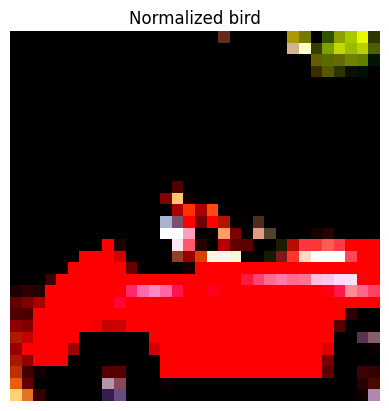

In [16]:
# Create a transform pipeline
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean.tolist(), std.tolist())
])

# Apply it to the dataset
transformed_cifar10 = datasets.CIFAR10(
    root=data_path, train=True, download=False, transform=transform
)

# Display a normalized image
img_t, label = transformed_cifar10[99]

plt.imshow(img_t.permute(1, 2, 0))
plt.title(f"Normalized {class_names[label]}")
plt.axis("off")
plt.show()

# 7.2 Distinguishing Birds from Airplanes

In this section, we’ll train a small neural network classifier to tell apart airplanes and birds from the CIFAR-10 dataset.
We’ll simplify CIFAR-10 into a two-class dataset (called CIFAR-2) and then build, train, and evaluate a simple fully connected network.

## 7.2.1 Creating a two-class subset of CIFAR-10

The original CIFAR-10 dataset has 10 classes (airplane, bird, car, cat, etc.).  
Here, we only keep **airplane (0)** and **bird (2)** and remap them to labels 0 and 1.  
This gives us a smaller dataset called CIFAR-2, which is perfect for testing binary classification.

In [7]:
import torch
from torchvision import datasets, transforms

# Transform: convert PIL image → Tensor
transform = transforms.ToTensor()

# Load CIFAR-10 training & validation datasets
cifar10 = datasets.CIFAR10(root="data", train=True, download=True, transform=transform)
cifar10_val = datasets.CIFAR10(root="data", train=False, download=True, transform=transform)

# Keep only classes airplane (0) and bird (2)
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']

cifar2 = [(img, label_map[label]) for img, label in cifar10 if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in cifar10_val if label in [0, 2]]

print(f"Training samples: {len(cifar2)}, Validation samples: {len(cifar2_val)}")

Training samples: 10000, Validation samples: 2000


## 7.2.2 Visualizing the dataset

Let’s plot a few airplane and bird images to confirm our dataset is correct.


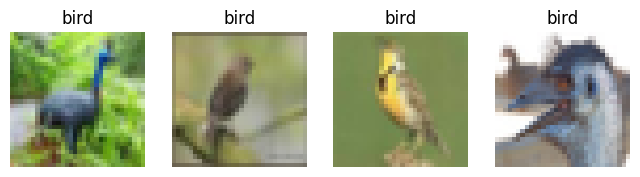

In [17]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 4, figsize=(8, 2))
for i, ax in enumerate(axes):
    img, label = cifar2[i * 100]
    ax.imshow(img.permute(1, 2, 0))  # reshape (C,H,W) → (H,W,C)
    ax.set_title(class_names[label])
    ax.axis("off")
plt.show()

## 7.2.3 Defining the model

Each 32×32 RGB image = 3072 features.  
We’ll flatten it and feed it to a simple feed-forward network:  
Input → Hidden (512) → Output (2 classes).


In [9]:
import torch.nn as nn

model = nn.Sequential(
    nn.Linear(3072, 512),  # Input layer → Hidden layer
    nn.Tanh(),             # Non-linear activation
    nn.Linear(512, 2),     # Hidden layer → Output (2 classes)
    nn.LogSoftmax(dim=1)   # Log-probabilities for stability
)

print(model)

Sequential(
  (0): Linear(in_features=3072, out_features=512, bias=True)
  (1): Tanh()
  (2): Linear(in_features=512, out_features=2, bias=True)
  (3): LogSoftmax(dim=1)
)


## 7.2.4 Preparing DataLoaders and optimizer

We’ll use DataLoader for batching,  
SGD for optimization,  
and Negative Log Likelihood Loss for classification.


In [10]:
from torch.utils.data import DataLoader
from torch import optim

train_loader = DataLoader(cifar2, batch_size=64, shuffle=True)
val_loader = DataLoader(cifar2_val, batch_size=64, shuffle=False)

learning_rate = 1e-2
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.NLLLoss()

## 7.2.5 Training loop

For each epoch:
1. Flatten images  
2. Compute log probabilities  
3. Calculate loss  
4. Backpropagate gradients  
5. Update weights


In [11]:
n_epochs = 10  # Number of epochs

for epoch in range(n_epochs):
    total_loss = 0.0
    for imgs, labels in train_loader:
        # Flatten images into 3072-length vectors
        batch_size = imgs.shape[0]
        outputs = model(imgs.view(batch_size, -1))

        # Compute loss
        loss = loss_fn(outputs, labels)

        # Reset gradients
        optimizer.zero_grad()

        # Backpropagation
        loss.backward()

        # Update parameters
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Training Loss: {total_loss/len(train_loader):.4f}")

Epoch 1, Training Loss: 0.5787
Epoch 1, Training Loss: 0.5787
Epoch 2, Training Loss: 0.5242
Epoch 2, Training Loss: 0.5242
Epoch 3, Training Loss: 0.5091
Epoch 3, Training Loss: 0.5091
Epoch 4, Training Loss: 0.5030
Epoch 4, Training Loss: 0.5030
Epoch 5, Training Loss: 0.4969
Epoch 5, Training Loss: 0.4969
Epoch 6, Training Loss: 0.4914
Epoch 6, Training Loss: 0.4914
Epoch 7, Training Loss: 0.4910
Epoch 7, Training Loss: 0.4910
Epoch 8, Training Loss: 0.4781
Epoch 8, Training Loss: 0.4781
Epoch 9, Training Loss: 0.4802
Epoch 9, Training Loss: 0.4802
Epoch 10, Training Loss: 0.4819
Epoch 10, Training Loss: 0.4819


## 7.2.6 Evaluating the trained model
We now test on the validation set and compute accuracy.


In [12]:
correct = 0
total = 0
with torch.no_grad():  # disable gradient tracking for evaluation
    for imgs, labels in val_loader:
        batch_size = imgs.shape[0]
        outputs = model(imgs.view(batch_size, -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Validation accuracy: {accuracy*100:.2f}%")

Validation accuracy: 80.20%


## 7.2.7 Visualizing predictions

Let’s check what our trained model predicts for some random images.


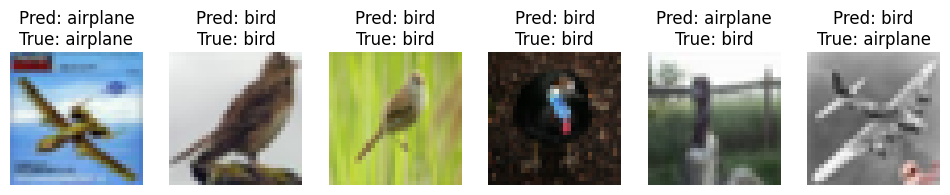

In [13]:
import random

fig, axes = plt.subplots(1, 6, figsize=(12, 3))
for ax in axes:
    img, label = random.choice(cifar2_val)
    with torch.no_grad():
        output = model(img.view(1, -1))
        pred = output.argmax(dim=1).item()

    ax.imshow(img.permute(1, 2, 0))
    ax.set_title(f"Pred: {class_names[pred]}\nTrue: {class_names[label]}")
    ax.axis("off")
plt.show()

## 7.2.8 Making the network deeper

We’ll add more hidden layers to increase capacity  
and switch to CrossEntropyLoss (which combines LogSoftmax + NLLLoss).


In [14]:
model_deep = nn.Sequential(
    nn.Linear(3072, 1024),
    nn.Tanh(),
    nn.Linear(1024, 512),
    nn.Tanh(),
    nn.Linear(512, 128),
    nn.Tanh(),
    nn.Linear(128, 2)
)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_deep.parameters(), lr=1e-2)
print(model_deep)

Sequential(
  (0): Linear(in_features=3072, out_features=1024, bias=True)
  (1): Tanh()
  (2): Linear(in_features=1024, out_features=512, bias=True)
  (3): Tanh()
  (4): Linear(in_features=512, out_features=128, bias=True)
  (5): Tanh()
  (6): Linear(in_features=128, out_features=2, bias=True)
)


## 7.2.9 Counting model parameters
Let’s check how many trainable parameters each model has.


In [15]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Simple model params:", count_parameters(model))
print("Deeper model params:", count_parameters(model_deep))

Simple model params: 1574402
Deeper model params: 3737474
